# Trabajo Práctico 0:  Algoritmo de Maximización de la Esperanza

**Profesor**: Saúl Calderón Ramírez

**Estudiantes**:

* Ricardo Chacon
* Marco Ferraro
* Gabriel Valentine


## 1. Algoritmo de Maximización de la Esperanza con datos artificiales

En esta sección se llevará a cabo una implementación de un algoritmo de maximización de la esperanza. Se utilizará un grupo de funciones base.

### 1.1 Generate Data

Esta función se encarga de generar observaciones aleatorias de `K` distribuciones Gaussianas. Por defecto `K` va a presentar valor de 2.  Se recibe de parametro `N` que representa la tolidad de puntos u observaciones que se quiere generar. Un array de medias y otro de desviaciones estandar de las distribuciones respectivas.

Cabe destacar que esta función retorna todas las observaciones en una matriz de dimension `Nx1`.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def generate_data(N, means: np.ndarray, stds: np.ndarray, K=2):
  if len(means) != len(stds):
    print("Error in dimensions")
    return None
  else:
    data = []
    for i in range(K):
      y = np.sqrt(-2 * np.log(np.random.rand(N // K))) * np.cos(2 * np.pi * np.random.rand(N // 2))
      y = (y * stds[i]) + means[i]

      data.append(y)

    X = np.concatenate(data)

    # Mezclar datos para que no esten ordenados
    np.random.shuffle(X)

    return X.reshape(-1, 1)



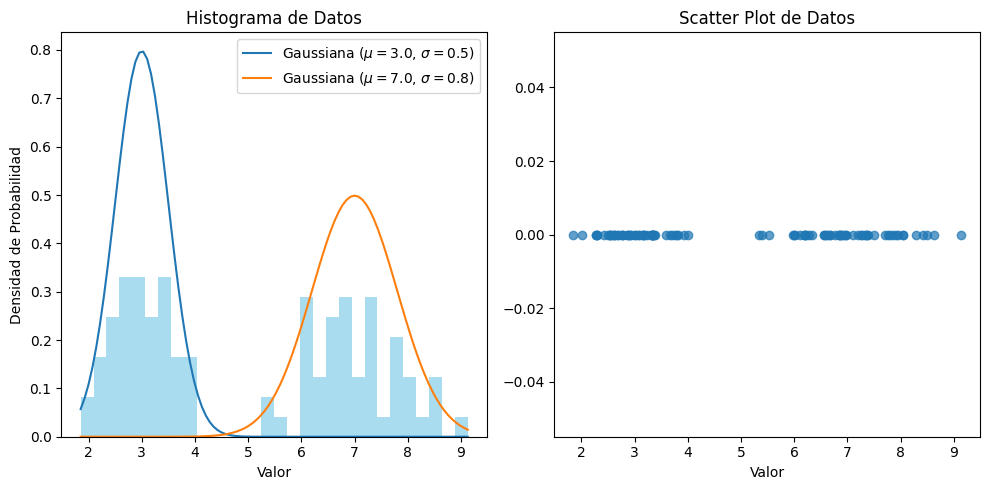

In [8]:
N = 100

means = [3.0, 7.0]
stds = [0.5, 0.8]

data = generate_data(N=100, means=means, stds=stds)

data = np.round(data, 3)

data

# Crear un histograma
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(data, bins=30, color='skyblue', alpha=0.7, density=True)
plt.title('Histograma de Datos')
plt.xlabel('Valor')
plt.ylabel('Densidad de Probabilidad')

# Generar las funciones de densidad de probabilidad Gaussianas
x = np.linspace(np.min(data), np.max(data), 100)
for mean, std in zip(means, stds):
    pdf = norm.pdf(x, mean, std)
    plt.plot(x, pdf, label=f'Gaussiana ($\mu={mean}$, $\sigma={std}$)')

plt.legend()

# Crear un scatter plot
plt.subplot(1, 2, 2)
plt.scatter(data, np.zeros_like(data), alpha=0.7)
plt.title('Scatter Plot de Datos')
plt.xlabel('Valor')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_data(data, title='Two Normal Distributions'):
    hist_values, bin_edges = np.histogram(data, bins=20)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(bin_edges[:-1], hist_values, width=np.diff(bin_edges), color='skyblue', alpha=0.7, label='Frequency')
    ax.scatter(data, np.zeros_like(data), marker='o', s=30, color='b', label='Data')

    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min - 0.5, y_max + 0.1)

    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.grid(True, which='both')

    ax.legend()
    plt.show()

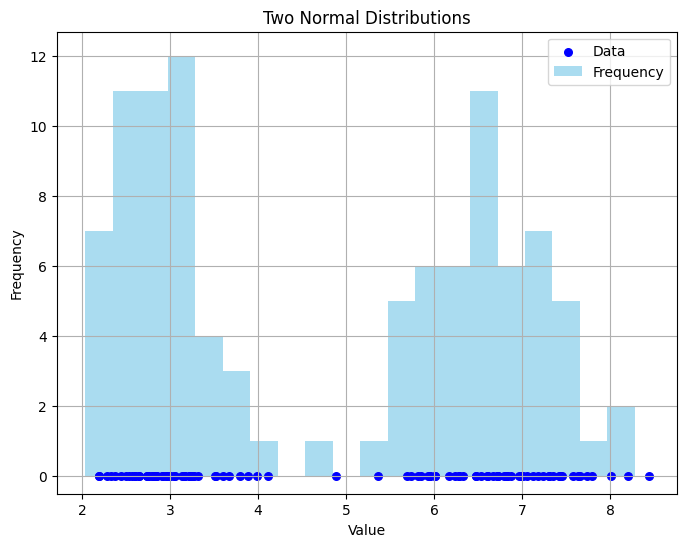

In [ ]:
plot_data(data)

In [ ]:

# El asterisco es para desempacar la tupla.
def init_random_parameters(K, mean_range=(0, 10), std_range=(0, 1)):
  means = np.random.uniform(*mean_range, size=K)
  stds = np.random.uniform(*std_range, size=K)

  params = np.column_stack((means, stds)).tolist()

  return params

In [ ]:
init_random_parameters(3)

[[7.065079293907514, 0.23386200242383015],
 [8.359163627456542, 0.481536877138774],
 [3.791742857806563, 0.45383778855691903],
 [1.9012224822214685, 0.17143595210428797],
 [7.437920981438372, 0.8207967987216976]]

In [ ]:
import numpy as np

def calculate_likelihood_gaussian_observation(x_n, mu_k, sigma_k):
    log_likelihood = -0.5 * np.log(2 * np.pi * sigma_k**2) - 0.5 * ((x_n - mu_k) / sigma_k)**2
    return log_likelihood

# Prueba Unitaria
x_n = 3.0
mu_k = 2.0
sigma_k = 1.0

likelihood = calculate_likelihood_gaussian_observation(x_n, mu_k, sigma_k)

# Comprobación
print(f'Likelihood: {likelihood}')


Likelihood: -1.4189385332046727


In [ ]:
import numpy as np

def calculate_membership_dataset(X_dataset, Parameters_matrix):
    N, K = X_dataset.shape[0], Parameters_matrix.shape[0]
    M = np.zeros((N, K))

    for i in range(N):
        for k in range(K):
            mu_k, sigma_k = Parameters_matrix[k]
            log_likelihood = calculate_likelihood_gaussian_observation(X_dataset[i], mu_k, sigma_k)
            M[i, k] = log_likelihood

    # Aplicar normalización softmax para obtener valores entre 0 y 1
    M = np.exp(M - np.max(M, axis=1, keepdims=True))
    M /= np.sum(M, axis=1, keepdims=True)

    return M

# Prueba Unitaria
X_dataset = np.array([[2.5], [3.0], [1.8], [2.2]])  # Ejemplo de dataset (4 observaciones)
Parameters_matrix = np.array([[2.0, 0.5], [3.0, 0.3]])  # Ejemplo de matriz de parámetros (2 clusters)

membership_matrix = calculate_membership_dataset(X_dataset, Parameters_matrix)

# Comprobación
print("Matriz de Membresía:")
print(membership_matrix)


Matriz de Membresía:
[[5.93405901e-01 4.06594099e-01]
 [7.51027396e-02 9.24897260e-01]
 [9.99394696e-01 6.05303929e-04]
 [9.50955067e-01 4.90449332e-02]]


In [ ]:
import torch

def recalculate_parameters(X_dataset, Membership_data):
    X_torch = torch.tensor(X_dataset, dtype=torch.float32)
    Membership_torch = torch.tensor(Membership_data, dtype=torch.float32)

    # Calcular nuevas medias
    new_means = torch.matmul(Membership_torch.T, X_torch) / torch.sum(Membership_torch, dim=0, keepdim=True)

    # Calcular nuevas desviaciones estándar
    deviations = X_torch.unsqueeze(1) - new_means
    squared_deviations = deviations ** 2
    weighted_squared_deviations = squared_deviations * Membership_torch.unsqueeze(2)
    new_std = torch.sqrt(torch.sum(weighted_squared_deviations, dim=0) / torch.sum(Membership_torch, dim=0, keepdim=True))

    return new_means.numpy(), new_std.numpy()

# Ejemplo de uso
X_dataset = np.array([[2.5], [3.0], [1.8], [2.2]], dtype=np.float32)
Membership_data = np.array([[0.2, 0.8], [0.6, 0.4], [0.3, 0.7], [0.9, 0.1]], dtype=np.float32)

new_means, new_std = recalculate_parameters(X_dataset, Membership_data)

print("Nuevas Medias:")
print(new_means)

print("\nNuevas Desviaciones Estándar:")
print(new_std)



Nuevas Medias:
[[2.41 2.41]
 [2.34 2.34]]

Nuevas Desviaciones Estándar:
[[0.4253234 0.4253234]
 [0.4476606 0.4476606]]
